[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/ZiyangS/AI_5010_4010_Deep_Learning/blob/main/MLP.ipynb)

# Multilayer Perceptron (MLP)
Our goal here is to implement a two-layer neural network for binary classification, train it using gradient descent and use it to classify the Iris dataset.
Our model is
$$
\hat{y} = \sigma \left(\sigma (x V) W \right)
$$
where we have $D$ input features and $M$ hidden units, leading to $V \in \mathbb{R}^{D \times M}$ and $w \in \mathbb{R}^{M \times 1}$. For simplicity here we do not include a bias parameter for each layer.

Key to our implementation is the gradient calculation. We follow the notation used in the slides here.

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

In [2]:
logistic = lambda z: 1./ (1 + np.exp(-z)) # logistic function for binary classification

class MLP:

    def __init__(self, M = 64):
        self.M = M

    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v, w = params
            z = logistic(np.dot(x, v)) #N x M
            yh = logistic(np.dot(z, w))#N
            dy = yh - y #N
            dw = np.dot(z.T, dy)/N #M
            dz = np.outer(dy, w) #N x M
            dv = np.dot(x.T, dz * z * (1 - z))/N #D x M
            dparams = [dv, dw]
            return dparams

        w = np.random.randn(self.M) * .01
        v = np.random.randn(D,self.M) * .01
        params0 = [v,w]
        self.params = optimizer.run(gradient, x, y, params0)
        return self

    def predict(self, x):
        v, w = self.params
        z = logistic(np.dot(x, v)) #N x M
        yh = logistic(np.dot(z, w))#N
        return yh

In the implementation above we have used a list data structure to maintain model parameters and their gradients. Below I have modified the `GradientDescent` class to also work with a list of parameters. One sournce of confusion in the above implementation is the gradient calculation. While in the slides during the lectures
we calculated the partial derivative for individual parameters, here, we use vector and matrix operations to calculate the derivative for *all* parameters.

In [3]:
class GradientDescent:

    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon

    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params

## Iris dataset
Let's apply this to do binary classification with Iris flowers dataset.
Below we run gradient descent for a large number of iterations and plot the decision boundary.

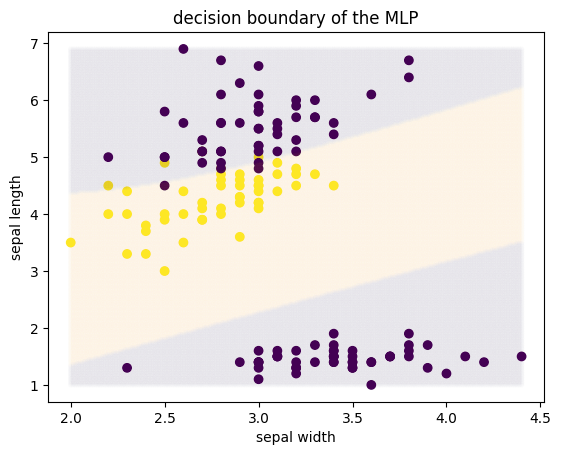

In [4]:
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,[1,2]], dataset['target']
y =  y == 1
model = MLP(M=32)
optimizer = GradientDescent(learning_rate=.1, max_iters=20000)
yh = model.fit(x, y, optimizer).predict(x)
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
yh_all = model.predict(x_all) > .5
plt.scatter(x[:,0], x[:,1], c=y, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.title('decision boundary of the MLP')
plt.show()

### Pytorch 2 layer MLP Implementation

Pytorch is a package that allows easier implementation of deep learning achitectures.  It's main benefits are easy implementation of the matrix computation operations and automatic differentiation.  Parameters and operations are tracked and the package computes the gradients automatically.  You can define MLPs as a `nn.Module` class. After layers are defined, you choose how they operate on the input using the `forward` function.

In [5]:
#Pytorch Implementation of a 2 Layer MLP
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

#We first define an nn.Module,
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    #Define the layers in your MLP
    self.fc1 = nn.Linear(2, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    #Define operations on input x using the layers that were defined
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x), dim =1)
    return x


Torch objects operate on `torch.Tensor` objects.  You must take all numpy datasets and convert them to the correct type of Tensor object.

Once the optimizer and loss function are defined, its easy to use them to update the parameters in the network.  An example training loop is below.

In [6]:
#Initalize your MLP
net = MLP()

#To use GPUs, set a device (cuda) and add it to your net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

#define hyperparameters
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

x, y = dataset['data'][:,[1,2]], dataset['target']
y =  y == 1

#The dataset must be converted to a tensor of the correct type
x_tensor = Variable(torch.from_numpy(x).float())
y_tensor   = Variable(torch.from_numpy(y)).long()

#Training loop
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    pred = net(x_tensor)

    optimizer.zero_grad()
    loss = loss_fn(pred, y_tensor)

    loss.backward()
    optimizer.step()

    print("Loss: ", loss)

print("Done!")




Epoch 1
-------------------------------
Loss:  tensor(0.8671, grad_fn=<NllLossBackward0>)
Epoch 2
-------------------------------
Loss:  tensor(0.7259, grad_fn=<NllLossBackward0>)
Epoch 3
-------------------------------
Loss:  tensor(0.6704, grad_fn=<NllLossBackward0>)
Epoch 4
-------------------------------
Loss:  tensor(0.6651, grad_fn=<NllLossBackward0>)
Epoch 5
-------------------------------
Loss:  tensor(0.6611, grad_fn=<NllLossBackward0>)
Epoch 6
-------------------------------
Loss:  tensor(0.6577, grad_fn=<NllLossBackward0>)
Epoch 7
-------------------------------
Loss:  tensor(0.6547, grad_fn=<NllLossBackward0>)
Epoch 8
-------------------------------
Loss:  tensor(0.6519, grad_fn=<NllLossBackward0>)
Epoch 9
-------------------------------
Loss:  tensor(0.6492, grad_fn=<NllLossBackward0>)
Epoch 10
-------------------------------
Loss:  tensor(0.6466, grad_fn=<NllLossBackward0>)
Epoch 11
-------------------------------
Loss:  tensor(0.6439, grad_fn=<NllLossBackward0>)
Epoch 12

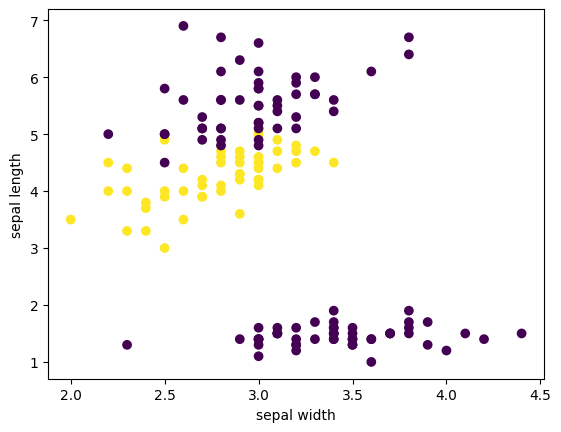

In [7]:
yh = net(x_tensor)
yh = torch.argmax(yh)
yh = yh.numpy()
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
plt.scatter(x[:,0], x[:,1], c=y, marker='o', alpha=1)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()